In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


# --- Limpieza de datos según lo indicado ---
df = pd.read_csv('Data/titanic.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']
df['Age'] = df['Age'].fillna(df.Age.mean())

# Variables predictoras y variable objetivo
X = df.drop('Survived', axis=1)
y = df['Survived']

# --- División en conjunto de entrenamiento y test (80%-20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# Crea un gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4)

model.fit(X_train, y_train)

predicciones=model.predict_proba(X_test)[:,1]

roc_auc_score(y_score=predicciones, y_true=y_test)

0.7930171277997365

In [12]:
## Cross validation 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('gbt', GradientBoostingClassifier(n_estimators=300))
])

params= {
    'gbt__max_depth': [2, 3, 4],
    'gbt__learning_rate': [0.1, 0.5, 0.01]
}

grid_gbt = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params).fit(X_train, y_train)

In [13]:
# Mejor estimador 
grid_gbt.best_params_

{'gbt__learning_rate': 0.1, 'gbt__max_depth': 2}

In [15]:
# AUC
best_model = grid_gbt.best_estimator_.named_steps['gbt']

predicciones = best_model.predict_proba(X_test)[:,1]

roc_auc_score(y_score=predicciones, y_true=y_test)


0.7951910408432148

In [5]:
## Calibracion

In [16]:
# Entendiendo el modelo 

importancia = pd.DataFrame({
    'features': X_train.keys(),
    'importancia': best_model.feature_importances_
})
importancia.sort_values('importancia')

,features,importancia
6,Embarked_C,0.000010
7,Embarked_Q,0.000134
3,Parch,0.007544
8,Embarked_S,0.017637
2,SibSp,0.025404
0,Pclass,0.148288
1,Age,0.154666
4,Fare,0.170173
5,Sex_male,0.476146


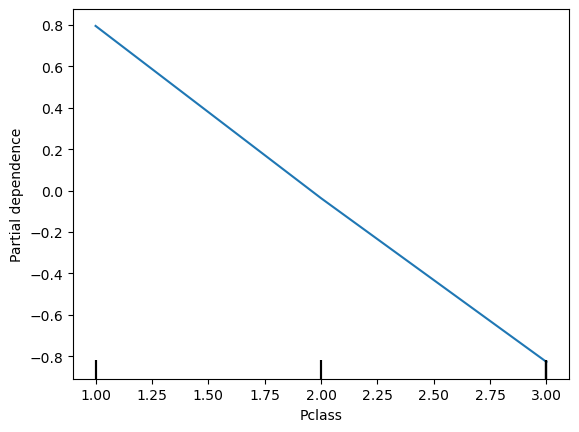

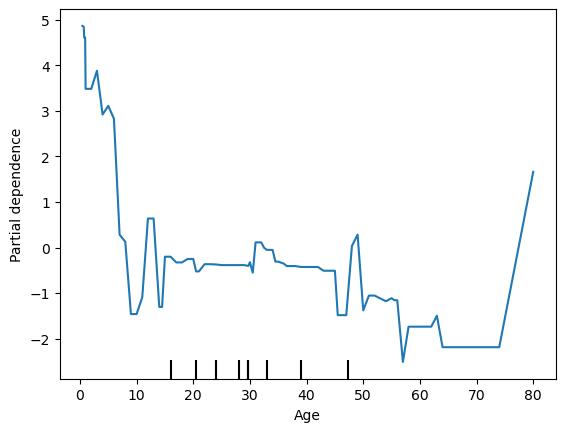

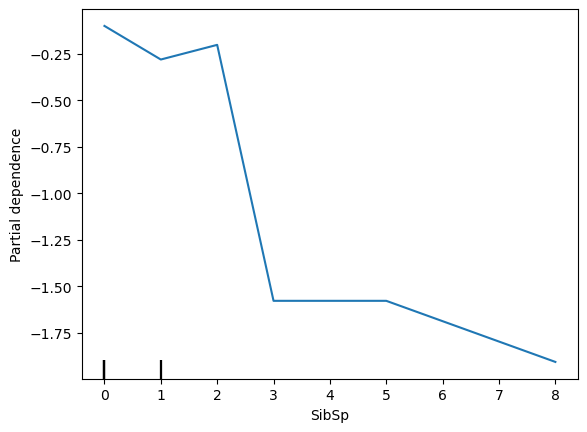

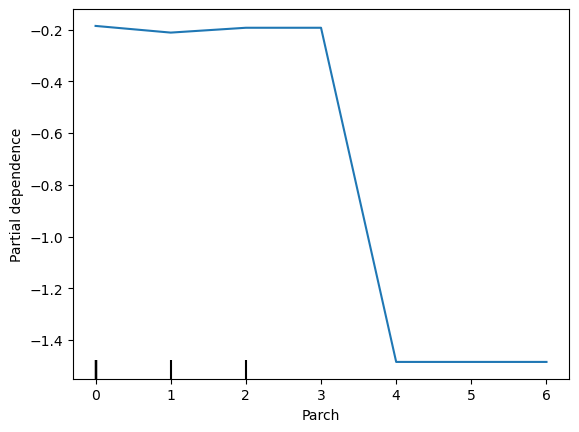

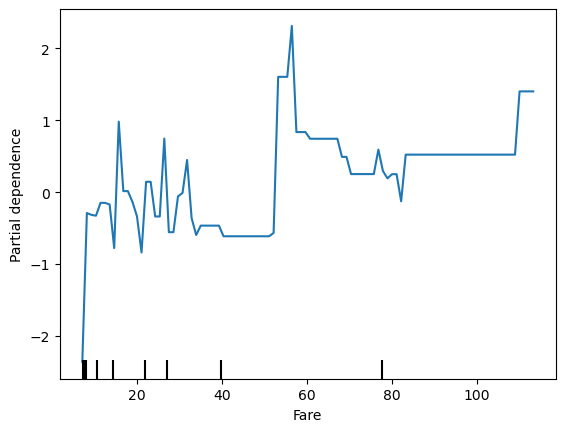

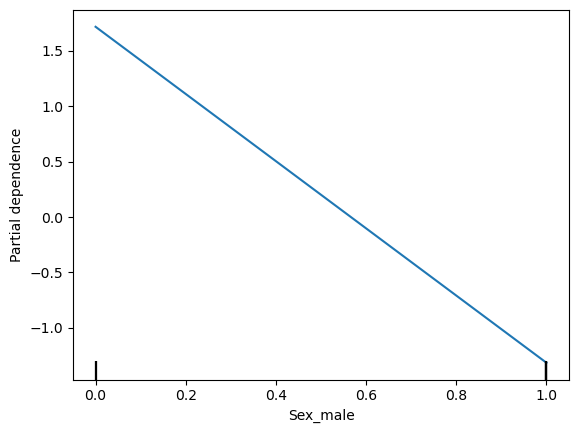

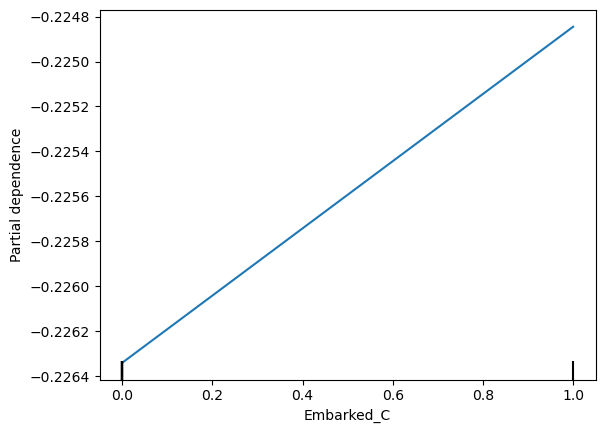

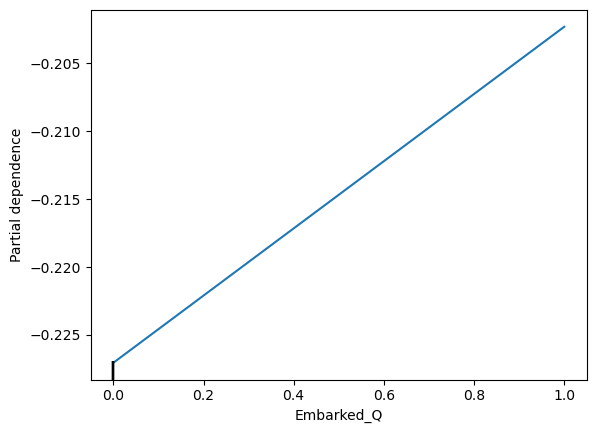

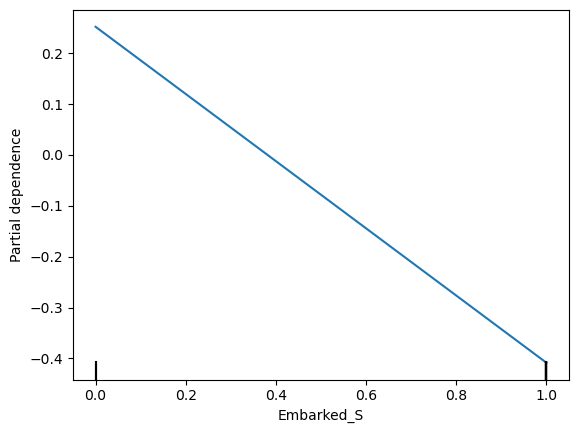

In [17]:
# Codigo for para partial dependence plot 
from sklearn.inspection import PartialDependenceDisplay

for i in range(len(X_train.keys())):
    PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    [i],
    feature_names=X_train.columns
    )